In [209]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import pyro.distributions.transforms as T

In [210]:
data = torch.randn(1024, 2) + 3

In [211]:
class PlanarFlow(nn.Module):
    """
    A single planar flow, computes T(x) and log(det(jac_T)))
    """
    def __init__(self, D):
        super(PlanarFlow, self).__init__()
        self.u = nn.Parameter(torch.Tensor(1, D), requires_grad=True)
        self.w = nn.Parameter(torch.Tensor(1, D), requires_grad=True)
        self.b = nn.Parameter(torch.Tensor(1), requires_grad=True)
        self.h = torch.tanh
        self.init_params()

    def init_params(self):
        self.w.data.uniform_(-0.01, 0.01)
        self.b.data.uniform_(-0.01, 0.01)
        self.u.data.uniform_(-0.01, 0.01)

    def forward(self, input):
        z, ljd = input
        ljd = ljd + self.log_det(z)
        linear_term = torch.mm(z, self.w.T) + self.b
        z_ = z + self.u * self.h(linear_term)
        return z_, ljd

    def h_prime(self, x):
        """
        Derivative of tanh
        """
        return (1 - self.h(x) ** 2)

    def psi(self, z):
        inner = torch.mm(z, self.w.T) + self.b
        return self.h_prime(inner) * self.w

    def log_det(self, z):
        inner = 1 + torch.mm(self.psi(z), self.u.T)
        return torch.log(torch.abs(inner))


In [216]:
#     def gaussian_nll(self, z, loc, scale):
#         return F.gaussian_nll_loss(loc, z, scale, full=True, reduction='none')


#  self.gaussian_nll(z, self.base_loc, self.base_logscale.exp()).sum(-1)

In [217]:
class NormalizingFlow(nn.Module):
    def __init__(self):
        super().__init__()
#         self.transforms = transforms
        self.d = 2
#         self.d = self.transforms[0].input_dim
        self.base_dist = torch.distributions.Normal
        self.base_loc = nn.Parameter(torch.zeros(self.d))
        self.base_logvar = nn.Parameter(torch.zeros(self.d))
#         self.trainable_transforms = nn.ModuleList(
#             [t for t in self.transforms if isinstance(t, nn.Module)]
#         )
        self.transforms = nn.Sequential(*[PlanarFlow(2) for _ in range(8)])
    
    
    def forward(self, x, ljd=0):
        z, ljd = self.transforms((x, ljd))
        return ljd + self.base_dist(self.base_loc, self.base_logvar.exp(), validate_args=False).log_prob(z)
    


In [218]:
model = NormalizingFlow()

In [219]:
model(data)

tensor([[ -3.3160,  -4.5388],
        [ -6.7580,  -6.1622],
        [ -4.2667,  -4.0290],
        ...,
        [ -2.5713, -11.9000],
        [ -5.2188,  -9.0025],
        [-13.5862,  -5.7302]], grad_fn=<AddBackward0>)

In [220]:
adam = Adam(model.parameters())

In [221]:
for i in range(2048):
    ll = model(data)
    loss = -ll.mean()
    adam.zero_grad()
    loss.backward()
    adam.step()
    
    if i % 32 == 0:
        print(f"{loss.item():.4f}")
    

5.9264
5.3818
4.5442
3.7203
3.1018
2.6769
2.3901
2.1963
2.0645
1.9735
1.9093
1.8624
1.8264
1.7975
1.7730
1.7514
1.7319
1.7139
1.6971
1.6813
1.6664
1.6523
1.6389
1.6262
1.6142
1.6027
1.5917
1.5812
1.5711
1.5614
1.5520
1.5427
1.5336
1.5244
1.5149
1.5049
1.4939
1.4814
1.4666
1.4492
1.4297
1.4097
1.3910
1.3747
1.3610
1.3497
1.3404
1.3325
1.3258
1.3200
1.3148
1.3102
1.3058
1.3018
1.2980
1.2944
1.2909
1.2876
1.2843
1.2812
1.2781
1.2752
1.2723
1.2695


In [222]:
with torch.no_grad():
    z, _ = model.transforms((data, 0))

In [223]:
import seaborn as sns

<AxesSubplot:>

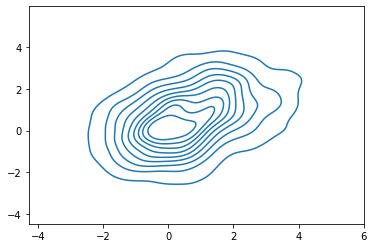

In [224]:
sns.kdeplot(x=z[:, 0], y=z[:, 1])

In [225]:
import functorch as ft


In [226]:
fmodel, params = ft.make_functional(model)


In [227]:
def flatten(params):
    return torch.cat([p.flatten() for p in params])

params_flat = flatten(params)

In [228]:
def unflatten(model, flattened_params):
    if flattened_params.dim() != 1:
        raise ValueError('Expecting a 1d flattened_params')
    params_list = []
    i = 0
    for val in list(model.parameters()):
        length = val.nelement()
        param = flattened_params[i:i+length].view_as(val)
        params_list.append(nn.Parameter(param))
        i += length

    return tuple(params_list)

In [229]:
def unflatten_batch(model, flattened_params):
    assert flattened_params.dim() == 2, "Expecting a [batch, params] tensor."
    i = 0
    params_list = []
    for val in list(model.parameters()):
        length = val.nelement()
        param = flattened_params[:, i:i+length].view(len(flattened_params), *val.shape)
        params_list.append(param)
        i += length

    return tuple(params_list)

In [230]:
batch_params = unflatten_batch(model, params_flat[None])

In [231]:
out = ft.vmap(fmodel, in_dims=(0, None))(batch_params, data)


In [232]:
out

tensor([[[-1.1618, -0.9018],
         [-0.7085, -0.5521],
         [-0.8462, -0.9497],
         ...,
         [-0.7925, -1.7825],
         [-0.6030, -1.1857],
         [-3.4935, -0.9063]]], grad_fn=<AddBackward0>)